In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
import string

In [3]:
cd ..

/data/nasif12/home_if12/chengju/project/news


In [4]:
fkn = pd.read_csv("./data/fake_real_news_dataset/fake_or_real_news.csv", index_col=0)

In [5]:
d = {"FAKE": 1, "REAL": 0}
fkn["label"] = fkn["label"].replace(d)

In [6]:
fkn = fkn.reset_index()

In [7]:
fkn.head()

,index,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


## Clean text data

### Tokenize

In [8]:
from nltk.tokenize import word_tokenize

In [9]:
fkn["text"] = fkn["text"].apply(word_tokenize)

In [10]:
fkn["title"] = fkn["title"].apply(word_tokenize)

In [11]:
fkn.text[0][:10]

['Daniel',
 'Greenfield',
 ',',
 'a',
 'Shillman',
 'Journalism',
 'Fellow',
 'at',
 'the',
 'Freedom']

### Remove punctuation

In [12]:
def rm_punctuation(tokenized):
    regex = re.compile('[%s]' % re.escape(string.punctuation)) 
    new_tokenized = []
    for token in tokenized:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_tokenized.append(new_token)
    return new_tokenized

In [13]:
rm_punctuation(fkn.text[0])[:10]

['Daniel',
 'Greenfield',
 'a',
 'Shillman',
 'Journalism',
 'Fellow',
 'at',
 'the',
 'Freedom',
 'Center']

In [14]:
fkn["text"] = fkn["text"].apply(rm_punctuation)
fkn["title"] = fkn["title"].apply(rm_punctuation)

In [15]:
fkn["title"] = fkn["title"].apply(rm_punctuation)

### Cleaning text of stopwords

In [16]:
from nltk.corpus import stopwords

def rm_stopwords(words):
    new_words = []
    for word in words:
        if not word in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [17]:
fkn["text"] = fkn["text"].apply(rm_stopwords)
fkn["title"] = fkn["title"].apply(rm_stopwords)

In [18]:
fkn["text"][0][:10]

['Daniel',
 'Greenfield',
 'Shillman',
 'Journalism',
 'Fellow',
 'Freedom',
 'Center',
 'New',
 'York',
 'writer']

### Stemming and Lemmatizing

In [19]:
#from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.wordnet import WordNetLemmatizer

#porter = PorterStemmer()
#wordnet = WordNetLemmatizer()

def stemming(words):
    snowball = SnowballStemmer('english')
    new_words = []
    for word in words:
        new_words.append(snowball.stem(word))
    return new_words

In [20]:
fkn["text"][0][100:104]

['entire', 'leftwing', 'establishment', 'form']

In [21]:
stemming(fkn["text"][0])[100:104]

['entir', 'leftw', 'establish', 'form']

In [22]:
fkn["text"] = fkn["text"].apply(stemming)
fkn["title"] = fkn["title"].apply(stemming)

## Pickle the output

In [42]:
fkn.shape

(6335, 4)

In [23]:
fkn.to_pickle("./data/fkn.gzip")

## Train validation test split

In [43]:
import numpy as np
import pandas as pd

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [44]:
train_dt, validate_dt, test_dt = train_validate_test_split(fkn, seed=8888)

In [45]:
print("training shape", train_dt.shape)
print("validating shape", validate_dt.shape)
print("testing shape", test_dt.shape)

training shape (3801, 4)
validating shape (1267, 4)
testing shape (1267, 4)


## tf-idf of text body

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [47]:
train_dt["text"] = train_dt["text"].apply(lambda x: " ".join(x))

In [48]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_dt.text)

In [49]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = train_dt["label"].as_matrix()

In [50]:
validate_dt["text"] = validate_dt["text"].apply(lambda x: " ".join(x))

In [51]:
X_val_counts = count_vect.transform(validate_dt.text)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
y_val = validate_dt["label"].as_matrix()

In [52]:
test_dt["text"] = test_dt["text"].apply(lambda x: " ".join(x))

In [53]:
X_test_counts = count_vect.transform(test_dt.text)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_test = test_dt["label"].as_matrix()

In [54]:
X_train_tfidf.shape

(3801, 50046)

(array([  3.48600000e+03,   2.52000000e+02,   3.80000000e+01,
          1.50000000e+01,   7.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    0. ,   974.8,  1949.6,  2924.4,  3899.2,  4874. ,  5848.8,
         6823.6,  7798.4,  8773.2,  9748. ]),
 <a list of 10 Patch objects>)

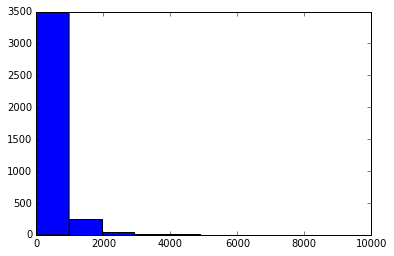

In [55]:
# Document lenght
plt.hist(X_train_counts.sum(1))

In [56]:
from src.helper import save_sparse_csr

In [57]:
save_sparse_csr("./data/X_train_tfidf", X_train_tfidf)
save_sparse_csr("./data/X_val_tfidf", X_val_tfidf)
save_sparse_csr("./data/X_test_tfidf", X_test_tfidf)

In [58]:
np.save("./data/y_train", y_train)
np.save("./data/y_val", y_val)
np.save("./data/y_test", y_test)

In [144]:
# X_train_tfidf = load_sparse_csr("./data/X_train_tfidf.npz")
# X_val_tfidf = load_sparse_csr("./data/X_val_tfidf.npz")
# X_test_tfidf = load_sparse_csr("./data/X_test_tfidf.npz")